# Import Libraries

In [906]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS
import matplotlib.pyplot as plt
import ta
%matplotlib inline

# Donwload Data from Yahoo Finance

## Data Selection

In [6]:
end = datetime.now()
start = datetime(2015, 1, 1)

# Stock Script Name

# change the stock accordingly 

In [7]:
# stock_x = "SBIN.NS"
stock_x = "ICICIBANK.NS"
# stock_x = "HDFCBANK.NS"
# stock_x = "AXISBANK.NS"

In [8]:
# stock_y = "HDFCBANK.NS"
# stock_y = "SBIN.NS"
stock_y = "AXISBANK.NS"
# stock_y = "ICICIBANK.NS"

# Donwloadding Data

In [9]:
x = yf.download(stock_x, start=start, end=end)
y = yf.download(stock_y, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
x.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.636353,321.318176,318.363647,320.272736,298.843292,2583280
2015-01-02,320.000000,330.454559,320.000000,329.363647,307.325958,8272990
2015-01-05,332.090912,334.000000,328.636353,330.045441,307.962128,10316090
2015-01-06,326.727264,327.181824,314.727264,316.045441,294.898804,13282427
2015-01-07,314.181824,314.772736,304.954559,307.500000,286.925201,21254332


# Co-integration and Dickey Fuller test

## Regress y on x

In [11]:
X = sm.add_constant(x['Adj Close'])
model = sm.OLS(y['Adj Close'], X).fit()
residuals = model.resid

## Test the residuals for stationarity

In [12]:
result = adfuller(residuals)

In [13]:
print('ADF Statistic: ' , result[0])

ADF Statistic:  -2.969309881570587


In [14]:
print('p-value:' , result[1])

p-value: 0.03786157698174173


In [15]:
if result[1] < 0.05:
    print("Residuals are stationary. X and Y are co-integrated.")
else:
    print("Residuals are non-stationary. X and Y are not co-integrated.")

Residuals are stationary. X and Y are co-integrated.


# Utilities Methods

## Z- score 

In [16]:
def rolling_zscore(data, window):
    return (data - data.rolling(window).mean()) / data.rolling(window).std()

## Signal Matrix Generation

In [17]:
# numpy signal generation
def signal_gen(inv, dx ,spread_diffs_window, dN, arr,lEThr, lCp, sEThr, sCp, hp):
    
    z_diff = spread_diffs_window[dN].values
    f_ret = inv[dx].values
    # intialize Z_Score_EQ
    arr[:,7] = 100
    # 1. Signal check independent
    for i, x in enumerate(z_diff):
        if x > sEThr:
            arr[i, 0] = -1
        elif x < lEThr:
            arr[i, 0] = 1
        else:
            arr[i, 0] = 0
    
    # 2. pos check 
    arr[-1, 5] = 0 # previous position in the position column
    for i, x in enumerate(z_diff):
        if (arr[i,0] == 0 and arr[i,1] == 0 and arr[i,2] == 0 and arr[i,4] == 0):
            arr[i,5] =  arr[i-1, 5]
        else:
            arr[i,5] = arr[i,0]
    
    # 3. Long Cap hit?
    for i, x in enumerate(z_diff):
        if(arr[i-1, 5] == 1 and x > lCp):
            arr[i,1] = 1
        else:
            arr[i,1] = 0
    
    # 4. Short Cap hit?
    for i, x in enumerate(z_diff):
        if(arr[i-1, 5] == -1 and x < sCp):
            arr[i,2] = 1
        else:
            arr[i,2] = 0
            
    # 4. Age Calculation
    arr[-1, 3] = 0 # previous position of Age calculation
    for i, x in enumerate(z_diff):
        if((arr[i-1, 5] == 0 and arr[i,0] != 0 ) or (arr[i-1, 5] * arr[i,0] == -1) or (arr[i-1, 3] == hp and arr[i,0] != 0)):
            arr[i,3] = 1
        elif ((arr[i,0] == 0 and arr[i-1,5] ==0) or (arr[i,1] == 1 or arr[i,2] == 1) or (arr[i-1,3] == hp)):
            arr[i,3] = 0
        else:
            arr[i,3] = arr[i-1,3] + 1
        
            
    # 5. Age5 check?
    for i, x in enumerate(z_diff):
        if(arr[i-1, 3] == hp):
            arr[i,4] = 1
        else:
            arr[i,4] = 0
    
    # 6. return calculation of z_score
    arr[-1,7] = 100
    for i, x in enumerate(z_diff):
        if(np.isnan(f_ret[i])):
            arr[i,6] = arr[i,5] * 0
            arr[i,7] = arr[i-1,7] * (1 + arr[i,6])
        else:
            arr[i,6] = arr[i,5] * f_ret[i]
            arr[i,7] = arr[i-1,7] * (1 + arr[i,6])
        
        
    return arr 

# Signal Count method

In [18]:
def signal_counts(signal_matrix,  longCap, shortCap):
    sgl_l_count, sgl_s_count = 0,0
    for i,x in enumerate(signal_matrix):
        if signal_matrix[i,0] == longCap:
            sgl_l_count += 1
        if signal_matrix[i,0] == shortCap:
            sgl_s_count += 1
    l_cap = signal_matrix[:,1].sum()
    s_cap = signal_matrix[:,2].sum()

    return sgl_l_count, sgl_s_count, l_cap, s_cap 

# Plotting signals and z-score

In [19]:
def z_score_signal_plt(sig_mat, dN, signal_name, lcap_name, scap_name):
    plt.figure(figsize=(25,7))
    plt.plot(sig_mat.index, sig_mat[dN], label='Z-Score',color='blue')

    # plts for signal
    plt.scatter(sig_mat[sig_mat[signal_name] == 1].index, sig_mat[sig_mat[signal_name] == 1][dN], color='green', label='Long Signal', marker='^')
    plt.scatter(sig_mat[sig_mat[signal_name] == -1].index, sig_mat[sig_mat[signal_name] == -1][dN], color='red', label='Short Signal', marker='v')

    # Adding labels and legend
    plt.axhline(0, color='gray', linestyle='--')
    # plt.yticks([-1,0,1],['Buy','N','Sell'])
    plt.yticks([-2, -1, 0, 1, 2], ['Buy Strong', 'Buy', 'Neutral', 'Sell', 'Sell Strong'])

    plt.title(signal_name + ' Trading Signals')
    plt.legend(loc='upper left')
    plt.show()

# Performace metrics

In [20]:
import math
def performace_metrics(df_signal_gen_x, fN, eqt_x, max_length):
    # Average returns
    h2= df_signal_gen_x[fN].mean()
    #print("Average returns: " , h2)
    # volatility (std)
    h3 = df_signal_gen_x[fN].std()
    #print("Std: " , h3)
    
    # Sharpe Ratio
    sR = math.sqrt(260) * (h2 / h3)
    #print("Sharpe Ratio:" ,sR)
    
    cum_ret = (df_signal_gen_x[eqt_x][max_length-1] - df_signal_gen_x[eqt_x][0]) / df_signal_gen_x[eqt_x][0]
    
    return ('Average returns:',h2), ('Volatility:',h3), ('Sharpe Ratio:',sR), ('Cum Ret:',cum_ret)

# Constants for signal Matrix

In [822]:
# Constants
longEntryThr = -2
longCap = 2
shortEntryThr = 2
shortCap = -2
holdingPeriod = 5

# plot graphs method

In [823]:
def plot_zscore_graph(script1, script2 ,zscore_col, longCap, shortCap):
    plt.figure(figsize=(15, 6))
    pd.concat([ script1[zscore_col] - script2[zscore_col] ], axis=1).plot()
    plt.axhline((script1[zscore_col] - script2[zscore_col]).mean(), color='yellow', linestyle='--')
    plt.axhline(longCap, color='red', linestyle='--')
    plt.axhline(shortCap, color='green', linestyle='--')

# Forming dataframes of stocks

In [824]:
df_x = pd.DataFrame()  # sbi
df_y = pd.DataFrame()  # Axis
df_x['Adj Close'] = x['Adj Close']
df_y['Adj Close'] = y['Adj Close']

In [825]:
df_y.head()

,Adj Close
Date,
2015-01-01,487.755188
2015-01-02,498.663116
2015-01-05,501.814331
2015-01-06,483.876801
2015-01-07,483.488922


# Ploting Adj close of stocks

Text(0.5, 1.0, 'Closing Price of Stocks')

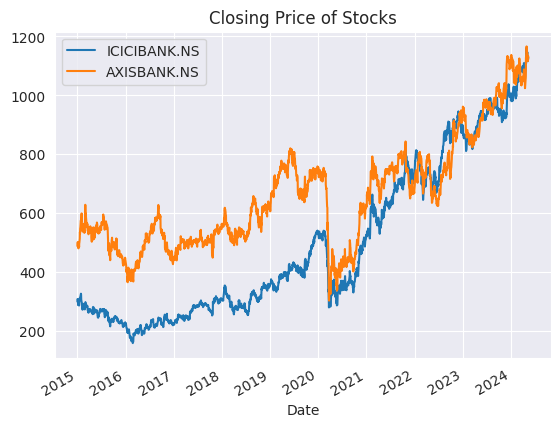

In [826]:
df_x['Adj Close'].plot()
df_y['Adj Close'].plot()
# (df_y['Adj Close'] - df_x['Adj Close']).plot()
plt.legend([stock_x, stock_y])
plt.title("Closing Price of Stocks")

Text(0.5, 1.0, 'Spread Difference')

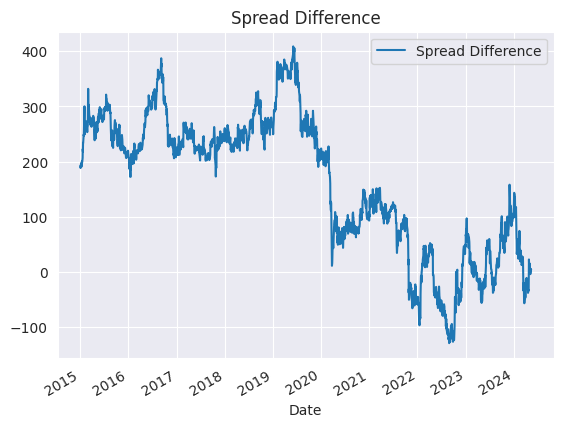

In [827]:
# df_x['Adj Close'].plot()
# df_y['Adj Close'].plot()
pd.concat([df_y['Adj Close'] - df_x['Adj Close']], axis=1).plot()
plt.legend(['Spread Difference'])
plt.title("Spread Difference")

# Cointegration Testing

In [828]:
# Conduct cointegration test
coint_score, p_value, critical_values = coint(df_y['Adj Close'].dropna(), df_x['Adj Close'].dropna())

In [829]:
# Display cointegration test results
print(f"Cointegration Test - Test Statistic: {coint_score}, P-value: {p_value}, Critical Values: {critical_values}")

Cointegration Test - Test Statistic: -2.970054664717046, P-value: 0.1174961882036884, Critical Values: [-3.90119148 -3.33877864 -3.04628812]


# Ratio of Stock Prices

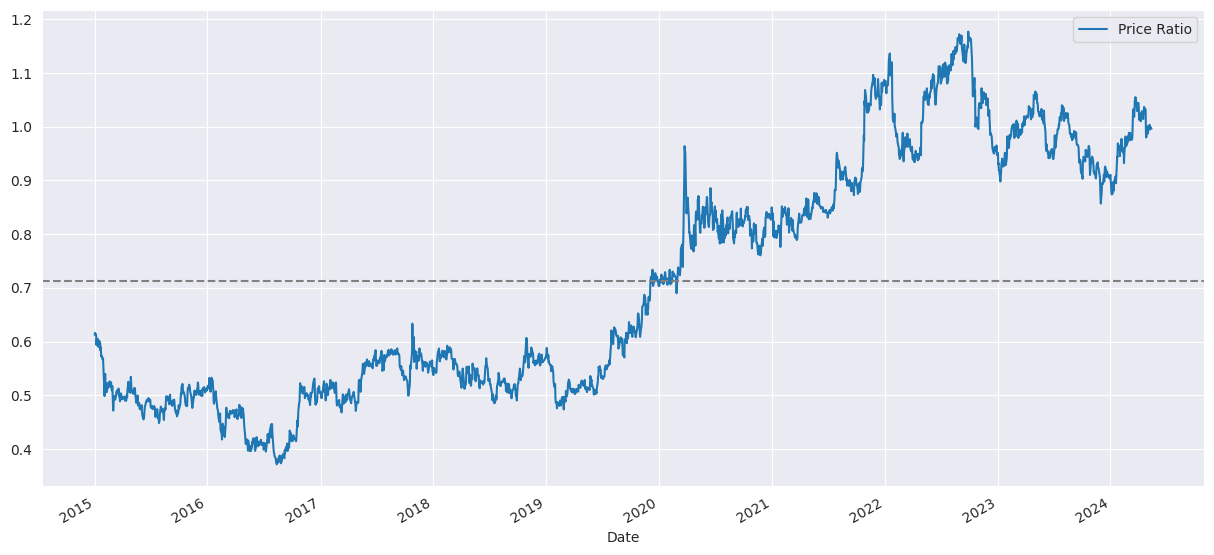

In [830]:
ratios = df_x['Adj Close'] / df_y['Adj Close']
ratios.plot(figsize = (15,7))
plt.axhline(ratios.mean(), color='gray', linestyle='--')
plt.legend(['Price Ratio'])
plt.show()

# Filling the dataframes of x and y with pct_returns, z_scores, vol_list

In [831]:
# x returns 1,5,10,20 days
df_x['pct_change_1'] = df_x['Adj Close'].pct_change()
df_x['pct_change_5'] = df_x['Adj Close'].pct_change(periods=5)
df_x['pct_change_10'] = df_x['Adj Close'].pct_change(periods=10)
df_x['pct_change_20'] = df_x['Adj Close'].pct_change(periods=20)

# y returns 1,5,10,20 days
df_y['pct_change_1'] = df_y['Adj Close'].pct_change(periods=1)
df_y['pct_change_5'] = df_y['Adj Close'].pct_change(periods=5)
df_y['pct_change_10'] = df_y['Adj Close'].pct_change(periods=10)
df_y['pct_change_20'] = df_y['Adj Close'].pct_change(periods=20)
        

## Normalized z-score

In [832]:
# Normalized scores of x 5,10,20
df_x['zscore_5'] = rolling_zscore(df_x['pct_change_5'], 60)
df_x['zscore_10'] = rolling_zscore(df_x['pct_change_10'], 60)
df_x['zscore_20'] = rolling_zscore(df_x['pct_change_20'], 60)

# Normalized scores of y 5,10,20
df_y['zscore_5'] = rolling_zscore(df_y['pct_change_5'], 60)
df_y['zscore_10'] = rolling_zscore(df_y['pct_change_10'], 60)
df_y['zscore_20'] = rolling_zscore(df_y['pct_change_20'], 60)

In [833]:
df_y.head(100)

,Adj Close,pct_change_1,pct_change_5,pct_change_10,pct_change_20,zscore_5,zscore_10,zscore_20
Date,,,,,,,,
2015-01-01,487.755188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,498.663116,0.022364,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,501.814331,0.006319,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,483.876801,-0.035745,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,483.488922,-0.000802,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-05-25,545.009888,-0.011518,-0.009515,0.019960,0.066098,-0.205150,0.374688,1.462704
2015-05-26,547.094482,0.003825,0.004987,0.059923,0.076402,0.052348,1.086273,1.592411
2015-05-27,560.232422,0.024014,0.035020,0.034557,0.080000,0.591179,0.606764,1.594116


# Z-score plots method call

<Figure size 1500x600 with 0 Axes>

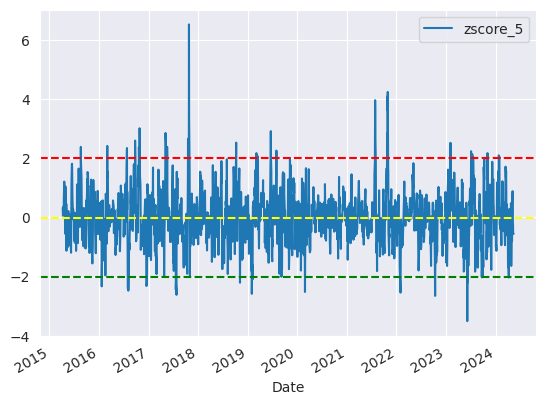

In [834]:
plot_zscore_graph(df_x,df_y,"zscore_5", longCap, shortCap)

# Spread Diffs in a dataframe

In [835]:
spread_diffs = pd.DataFrame()
spread_diffs['z_score_5_diff'] = df_x['zscore_5'] - df_y['zscore_5']
spread_diffs['z_score_10_diff'] = df_x['zscore_10'] - df_y['zscore_10']
spread_diffs['z_score_20_diff'] = df_x['zscore_20'] - df_y['zscore_20']

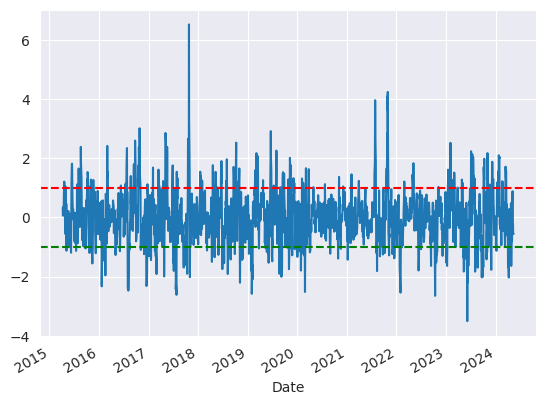

In [908]:
spread_diffs['z_score_5_diff'].plot()
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')

In [924]:
# Initialize RSI Indicator with a 14-day window
rsi_icici = ta.momentum.RSIIndicator(close=df_x['Adj Close'], window=5)
rsi_axis = ta.momentum.RSIIndicator(close=df_y['Adj Close'], window=5)

df_x['rsi_icici'] = rsi_icici.rsi()
df_y['rsi_axis'] = rsi_axis.rsi()

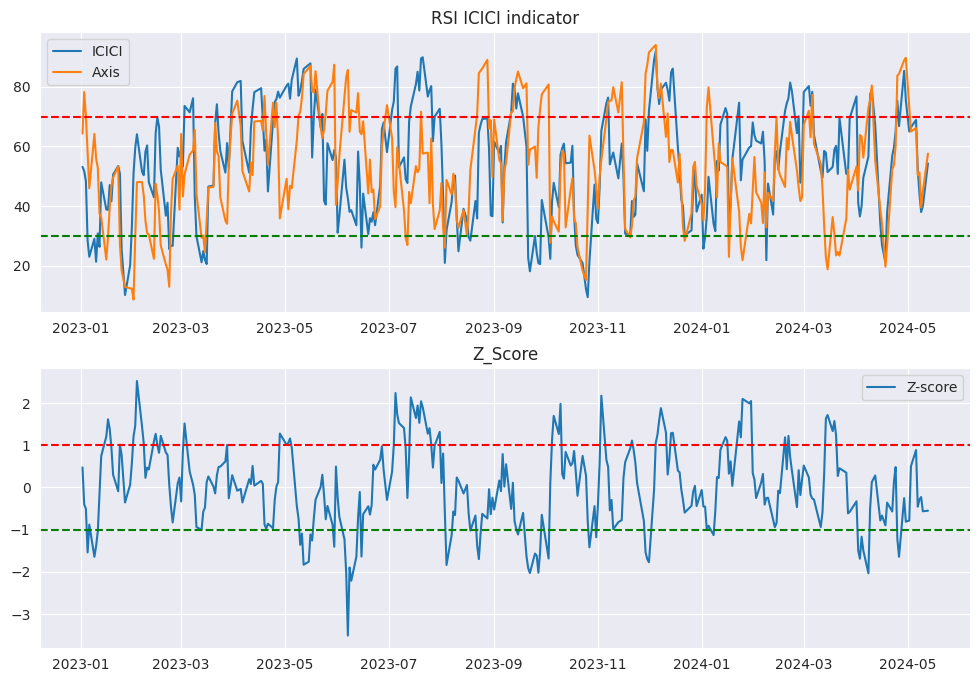

In [926]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(df_x['rsi_icici'].loc['2023-01-01':'2024-12-31'], label='RSI')
ax1.plot(df_y['rsi_axis'].loc['2023-01-01':'2024-12-31'], label='RSI')
ax1.axhline(70, linestyle='--', color='red')
ax1.axhline(30, linestyle='--', color='green')
ax1.set_title('RSI ICICI indicator')
ax1.legend(['ICICI','Axis'])

ax2.plot(spread_diffs['z_score_5_diff'].loc['2023-01-01':'2024-12-31'], label='Z-score')
# ax3.axhline(70, linestyle='--', color='red')
# ax3.axhline(30, linestyle='--', color='green')
ax2.set_title('Z_Score')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
ax2.legend()


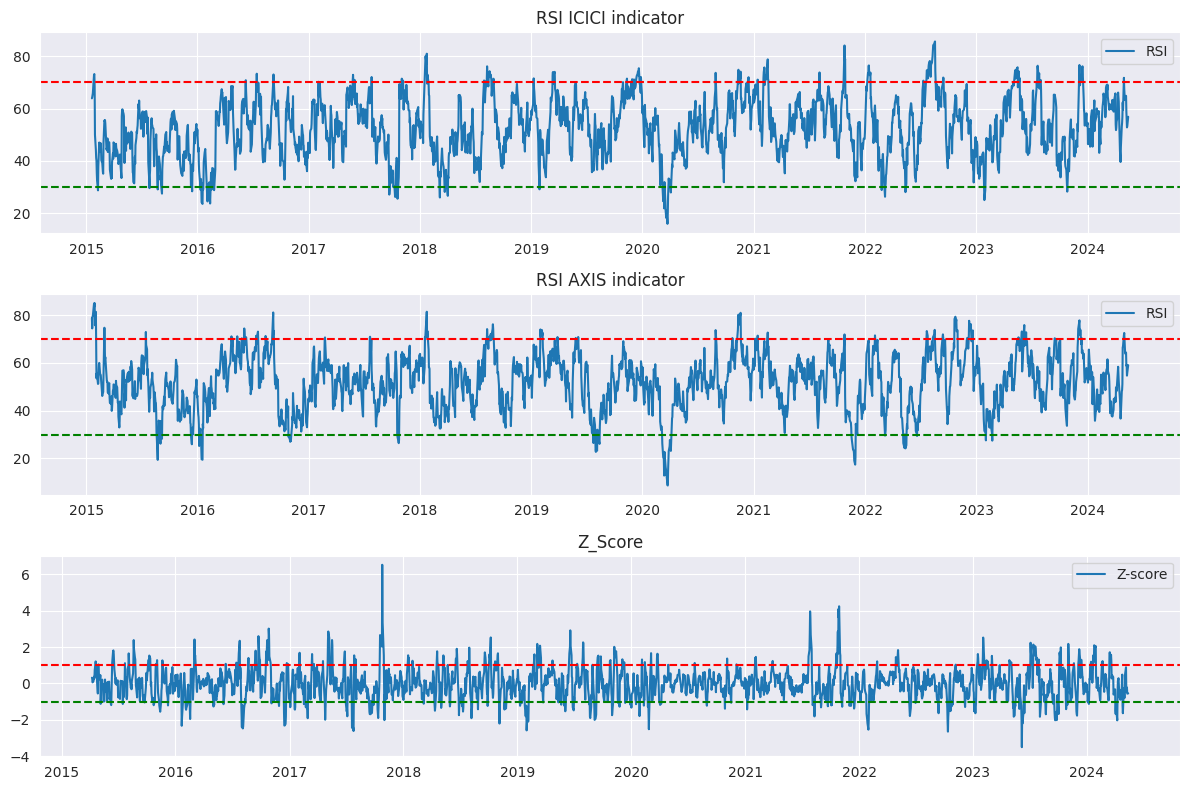

In [917]:
# Plot the closing prices and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
ax1.plot(df_x['rsi_icici'], label='RSI')
ax1.axhline(70, linestyle='--', color='red')
ax1.axhline(30, linestyle='--', color='green')
ax1.set_title('RSI ICICI indicator')
ax1.legend()

ax2.plot(df_y['rsi_axis'], label='RSI')
ax2.axhline(70, linestyle='--', color='red')
ax2.axhline(30, linestyle='--', color='green')
ax2.set_title('RSI AXIS indicator')
ax2.legend()


ax3.plot(spread_diffs['z_score_5_diff'], label='Z-score')
# ax3.axhline(70, linestyle='--', color='red')
# ax3.axhline(30, linestyle='--', color='green')
ax3.set_title('Z_Score')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
ax3.legend()

plt.tight_layout()
plt.show()

# Inverse Volatility calculation

In [837]:
# Inverse volatility calculation (weight calculation and future returns)
def inv_vol(df_x, df_y):
    
    inv_vol_anal = pd.DataFrame() # create a dataframe
    vol_df = pd.DataFrame()
    vol_df['x_vol'] = df_x['pct_change_1'].rolling(window=20).std()
    vol_df['y_vol'] = df_y['pct_change_1'].rolling(window=20).std()
    
    # weight allocations of sbi and axis
    inv_vol_anal['max_wt'] = vol_df[['x_vol','y_vol']].max(axis=1)
    inv_vol_anal['x_wt_init'] = inv_vol_anal['max_wt'] / vol_df['x_vol']
    inv_vol_anal['y_wt_init'] = 1 
    inv_vol_anal['sum_wt_init'] =  inv_vol_anal['x_wt_init'] + inv_vol_anal['y_wt_init']
    # weight ratios of sbi and axis
    inv_vol_anal['x_wt'] = inv_vol_anal['x_wt_init'] / inv_vol_anal['sum_wt_init']
    inv_vol_anal['y_wt'] = inv_vol_anal['y_wt_init'] / inv_vol_anal['sum_wt_init']
    # Furture returns
    inv_vol_anal['Fret_1'] = (inv_vol_anal['x_wt'] * df_x['pct_change_1'].shift(-1)) - (inv_vol_anal['y_wt'] * df_y['pct_change_1'].shift(-1)) 
    
    return inv_vol_anal

In [838]:
inverse_vol = inv_vol(df_x, df_y)

# X Method calls here for signal generation and others

## X.1 Intialize numpy array with (2299 x 8) for signal matrix and combo returns and equity

In [839]:
max_length = df_x.shape[0]

In [840]:
# initialize numpy array with (2299 x 7)
signal_5_arr = np.zeros((max_length, 8))
signal_10_arr = np.zeros((max_length, 8))
signal_20_arr = np.zeros((max_length, 8))

combo_ret1 = np.zeros((max_length, 2))

# X.1.1 signal gen for 5 day

In [841]:
signal_gen(inverse_vol,'Fret_1',spread_diffs,'z_score_5_diff', signal_5_arr, longEntryThr, longCap, shortEntryThr,shortCap, holdingPeriod) # for z_diff_5

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00, -1.14364712e-03,  9.38623210e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  7.27537473e-04,  9.39306094e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  9.39306094e+01]])

# X.1.2 signal gen for 10 day

In [842]:
signal_gen(inverse_vol,'Fret_1',spread_diffs,'z_score_10_diff', signal_10_arr, longEntryThr, longCap, shortEntryThr,shortCap, holdingPeriod) # for z_diff_10

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00, -1.14364712e-03,  8.18108308e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  7.27537473e-04,  8.18703512e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  8.18703512e+01]])

# X.1.3 Signal gen for 20 day

In [843]:
signal_gen(inverse_vol,'Fret_1',spread_diffs,'z_score_20_diff', signal_20_arr, longEntryThr, longCap, shortEntryThr,shortCap, holdingPeriod) # for z_diff_20

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00, -1.14364712e-03,  1.70834937e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  7.27537473e-04,  1.70959226e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.70959226e+02]])

# X.2 Signal Counts for z_diff 5, 10 and 20

In [844]:
signal_counts(signal_5_arr, longCap, shortCap)  # z-diff 5

(0, 0, 11.0, 12.0)

In [845]:
signal_counts(signal_10_arr, longCap, shortCap)  # z-diff 10

(0, 0, 8.0, 9.0)

In [846]:
signal_counts(signal_20_arr, longCap, shortCap)  # z-diff 20

(0, 0, 10.0, 10.0)

# X.3 Signal matrix converted to pd dataframes

In [847]:
# numpy array to dataframe
df_signal_gen_5 = pd.DataFrame()
df_signal_gen_5 = pd.DataFrame(signal_5_arr, columns=['signal5', 'lcap5', 'scap5', 'Age5','Aged5','pos5','fret_z5','Z5EQ'])

In [848]:
df_signal_gen_10 = pd.DataFrame()
df_signal_gen_10 = pd.DataFrame(signal_10_arr, columns=['signal10', 'lcap10', 'scap10', 'Age10','Aged10','pos10','fret_z10','Z10EQ'])

In [849]:
df_signal_gen_20 = pd.DataFrame()
df_signal_gen_20 = pd.DataFrame(signal_20_arr, columns=['signal20', 'lcap20', 'scap20', 'Age20','Aged20','pos20','fret_z20','Z20EQ'])

In [850]:
df_signal_gen_20

,signal20,lcap20,scap20,Age20,Aged20,pos20,fret_z20,Z20EQ
0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,100.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,100.000000
...,...,...,...,...,...,...,...,...
2304,0.0,0.0,0.0,2.0,0.0,1.0,-0.004718,170.751551
2305,0.0,0.0,0.0,3.0,0.0,1.0,0.001634,171.030536
2306,0.0,0.0,0.0,4.0,0.0,1.0,-0.001144,170.834937
2307,0.0,0.0,0.0,5.0,0.0,1.0,0.000728,170.959226


In [851]:
# Comob returns and combo equity graphs
# , gen_10, gen_20
def combo_ret(combo_ret, gen_5, gen_10, gen_20):
    
    gen_5_v = gen_5['fret_z5'].values
    gen_10_v = gen_10['fret_z10'].values
    gen_20_v = gen_20['fret_z20'].values
    combo_ret[-1,1] = 100
    for i,x in enumerate(combo_ret):
        # print((gen_5_v[i] + gen_10_v[i] + gen_20_v[i])/3.0)
        combo_ret[i,0] = (gen_5_v[i] + gen_10_v[i] + gen_20_v[i])/3.0
        combo_ret[i,1] = combo_ret[i-1,1] * (1 + combo_ret[i, 0])
    
    return combo_ret

In [852]:
# combo_ret(combo_ret1, df_signal_gen_5, df_signal_gen_10, df_signal_gen_20)
combo_ret(combo_ret1, df_signal_gen_5, df_signal_gen_10, df_signal_gen_20)

array([[ 0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  1.00000000e+02],
       [ 0.00000000e+00,  1.00000000e+02],
       ...,
       [-1.14364712e-03,  1.14699342e+02],
       [ 7.27537473e-04,  1.14782790e+02],
       [ 0.00000000e+00,  1.14782790e+02]])

## Convert the combo returns and equtiie values to pd Dataframe

In [853]:
# numpy array to dataframe
combo_re = pd.DataFrame()
combo_re = pd.DataFrame(combo_ret1, columns=['combo_ret','comboEQ'])

# Storing z-score and signal column in a dataframes

In [854]:
# New dataframe
df_plot_signal = pd.DataFrame()
df_plot_signal['z_score_5'] = spread_diffs['z_score_5_diff']
df_plot_signal['z_score_10'] = spread_diffs['z_score_10_diff']
df_plot_signal['z_score_20'] = spread_diffs['z_score_20_diff']

# signals 
df_plot_signal['signal5'] = df_signal_gen_5['signal5'].values
df_plot_signal['signal10'] = df_signal_gen_10['signal10'].values
df_plot_signal['signal20'] = df_signal_gen_20['signal20'].values

# Z-score and signal method call plots

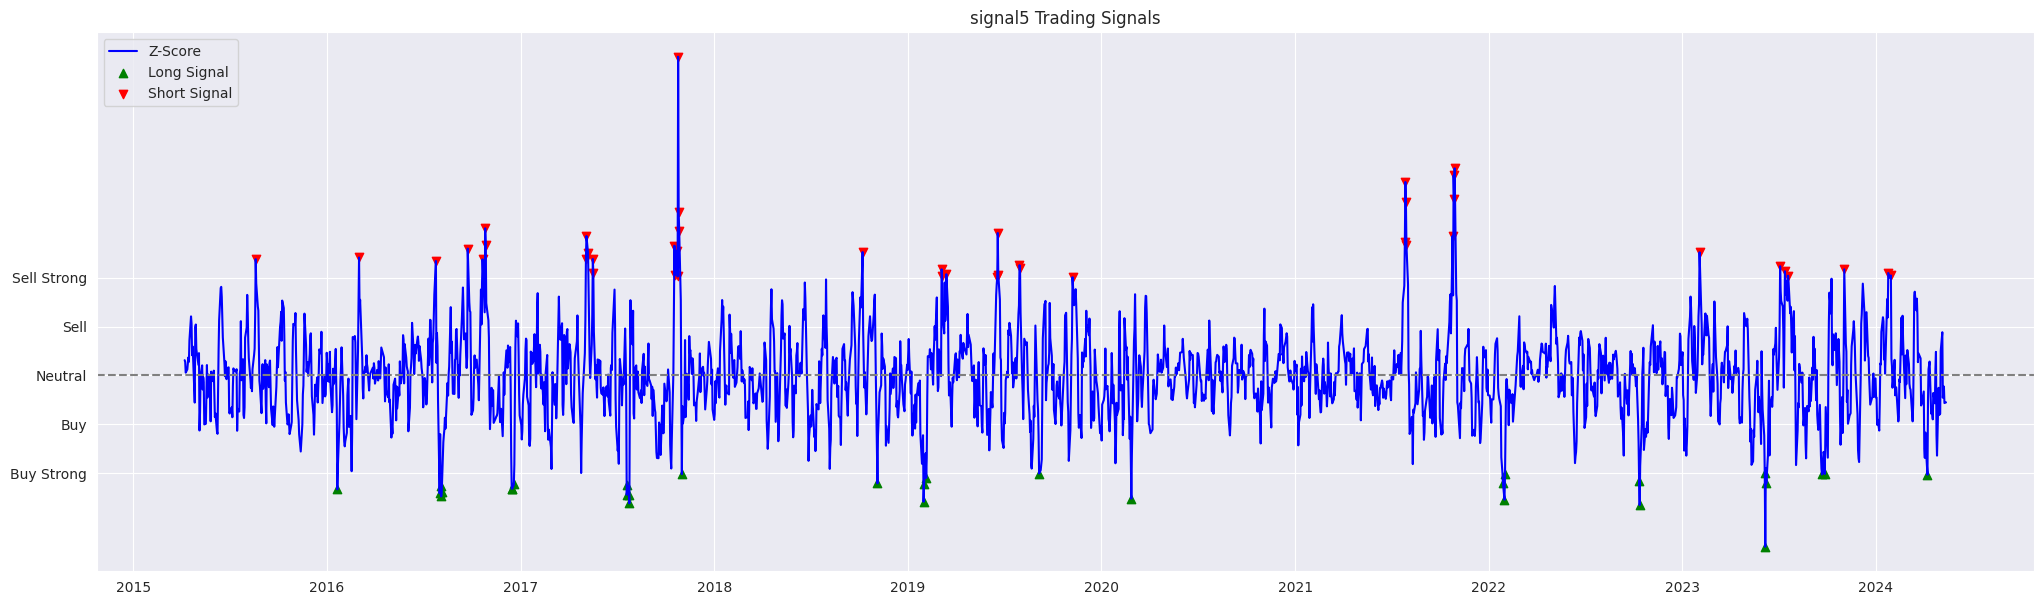

In [855]:
z_score_signal_plt(df_plot_signal, 'z_score_5', 'signal5', 'lcap5', 'scap5')

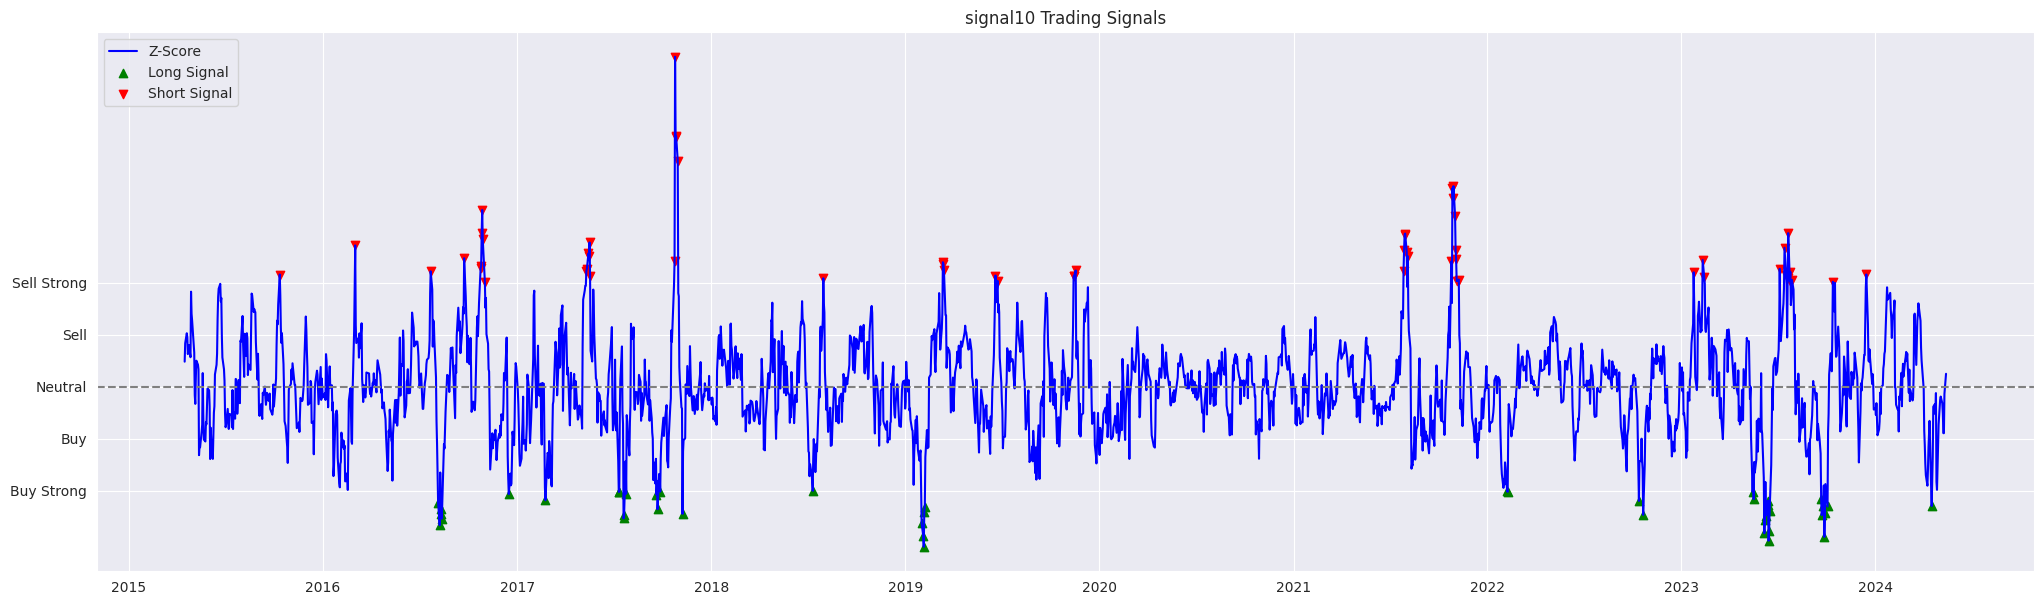

In [856]:
z_score_signal_plt(df_plot_signal, 'z_score_10', 'signal10', 'lcap10', 'scap10')

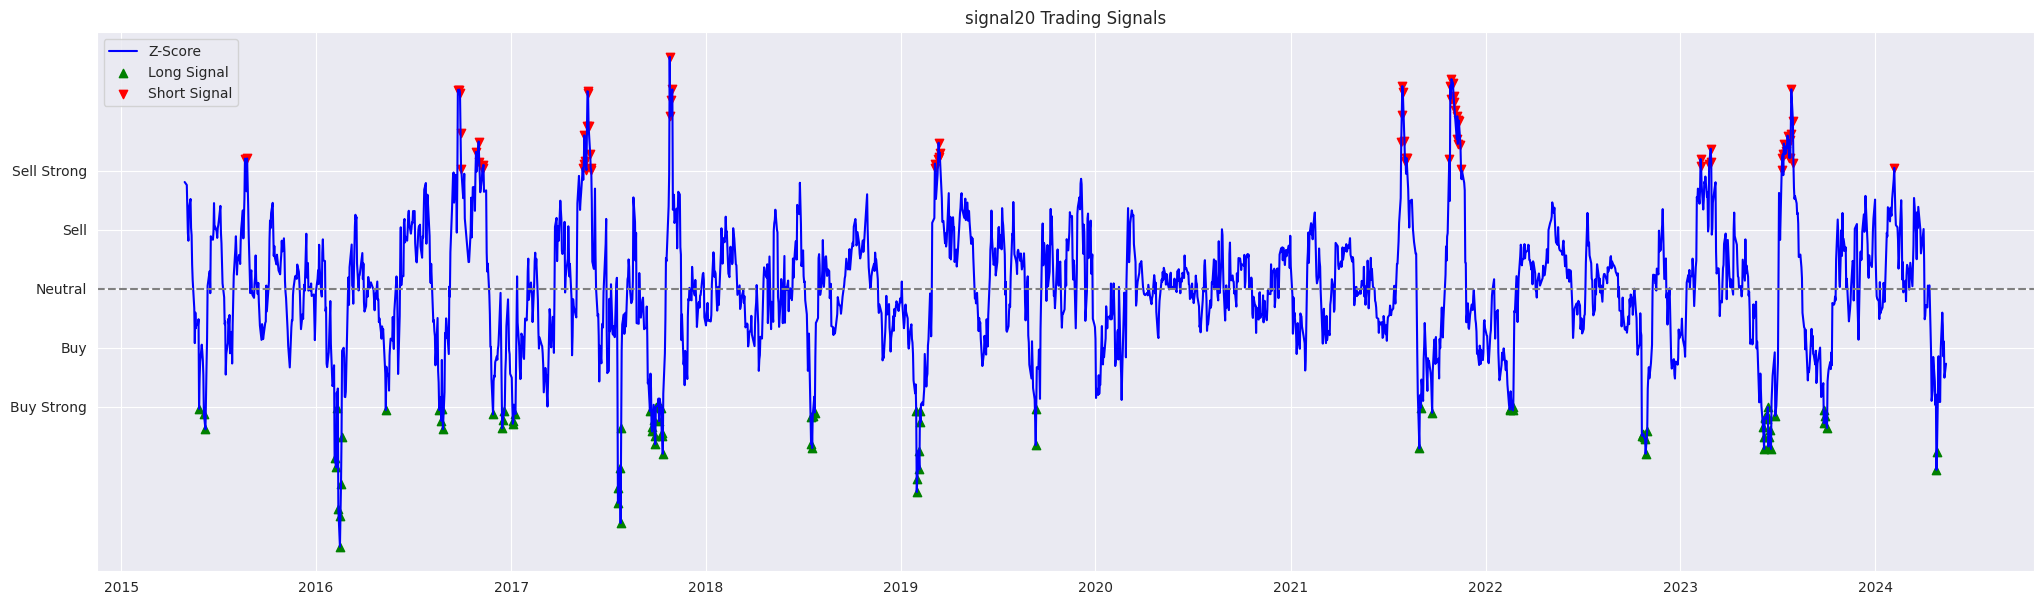

In [857]:
z_score_signal_plt(df_plot_signal, 'z_score_20', 'signal20', 'lcap20', 'scap20')

# Performance metrics

In [858]:
performace_metrics(df_signal_gen_5, 'fret_z5', 'Z5EQ', max_length)

(('Average returns:', 8.100832545021798e-06),
 ('Volatility:', 0.008389347245252143),
 ('Sharpe Ratio:', 0.015569983705402843),
 ('Cum Ret:', -0.06069390631861879))

In [859]:
performace_metrics(df_signal_gen_10, 'fret_z10', 'Z10EQ', max_length)

(('Average returns:', -5.186070909975967e-05),
 ('Volatility:', 0.008331166173339094),
 ('Sharpe Ratio:', -0.100373559972869),
 ('Cum Ret:', -0.1812964877562446))

In [860]:
performace_metrics(df_signal_gen_20, 'fret_z20', 'Z20EQ', max_length)

(('Average returns:', 0.00026800297989223326),
 ('Volatility:', 0.008467308814108686),
 ('Sharpe Ratio:', 0.5103650164744122),
 ('Cum Ret:', 0.7095922600148284))

# Equity Graph Plots for Z5,Z10 and Z20

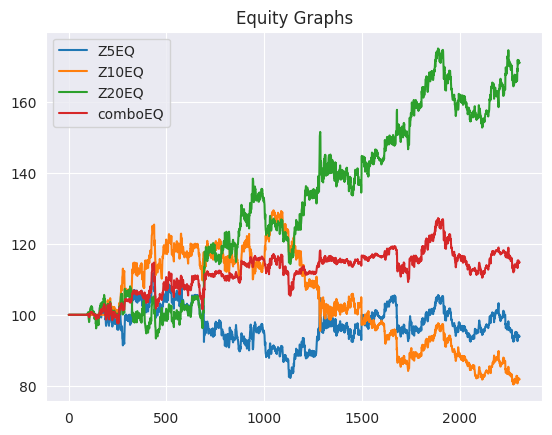

In [861]:
df_signal_gen_5['Z5EQ'].plot()
df_signal_gen_10['Z10EQ'].plot()
df_signal_gen_20['Z20EQ'].plot()
combo_re['comboEQ'].plot()
plt.title('Equity Graphs')
plt.legend()

# Assignment Machine Leanring analysis using the same label generations


In [862]:
data_mlF = pd.DataFrame()

In [863]:
data_mlF['ICICI'] = df_x['Adj Close']

In [864]:
data_mlF['AXIS'] = df_y['Adj Close']
data_mlF['ICICI_ret'] = df_x['pct_change_1']
data_mlF['AXIS_ret'] = df_y['pct_change_1']

In [865]:
data_mlF.reset_index(inplace = True)

In [866]:
data_mlF['z_score_5_diff_x'] = spread_diffs[['z_score_5_diff']].values
data_mlF['z_score_20_diff_x'] = spread_diffs[['z_score_20_diff']].values

In [867]:
# moving averages of z-scores of 5-day

In [868]:
zscore_mavg5_diff = data_mlF['z_score_5_diff_x'].rolling(window=5, center=False).mean()
zscore_mavg20_diff = data_mlF['z_score_5_diff_x'].rolling(window=20, center=False).mean()

std_20 = data_mlF['z_score_5_diff_x'].rolling(window=20, center=False).std()
#zscore_20_5 = (zscore_mavg5_diff - zscore_mavg20_diff) / std_20

In [869]:
data_mlF['zscore_diff_mavg_5'] = zscore_mavg5_diff
data_mlF['zscore_diff_mavg_20'] = zscore_mavg20_diff
data_mlF['std_20'] = std_20
#data_mlF['zscore_diff_5_20'] = zscore_20_5

In [870]:
# moving averages of z-scores of 20 day

In [871]:
zscore_20_mavg20_diff = data_mlF['z_score_20_diff_x'].rolling(window=20, center=False).mean()
zscore_20_mavg80_diff = data_mlF['z_score_20_diff_x'].rolling(window=80, center=False).mean()

std_80 = data_mlF['z_score_20_diff_x'].rolling(window=80, center=False).std()
#zscore_80_20 = (zscore_20_mavg20_diff - zscore_20_mavg80_diff) / std_80

In [872]:
data_mlF['zscore_20_diff_mavg_20'] = zscore_mavg5_diff
data_mlF['zscore_20_diff_mavg_80'] = zscore_mavg20_diff
data_mlF['std_80'] = std_80
#data_mlF['zscore_20_diff_20_80'] = zscore_80_20

In [873]:
# Signal Plots

In [874]:
data_mlF['Signal5_label'] = df_signal_gen_5['pos5'].values
data_mlF['Signal20_label'] = df_signal_gen_20['pos20'].values

In [875]:
data_mlF['ICIC_mean'] = data_mlF['ICICI_ret'].rolling(window=5, center=False).mean()
data_mlF['AXIS_mean'] = data_mlF['AXIS_ret'].rolling(window=5, center=False).mean()

In [876]:
data_mlF

,Date,ICICI,AXIS,ICICI_ret,AXIS_ret,z_score_5_diff_x,z_score_20_diff_x,zscore_diff_mavg_5,zscore_diff_mavg_20,std_20,zscore_20_diff_mavg_20,zscore_20_diff_mavg_80,std_80,Signal5_label,Signal20_label,ICIC_mean,AXIS_mean
0,2015-01-01,298.843292,487.755188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,2015-01-02,307.325958,498.663116,0.028385,0.022364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,2015-01-05,307.962128,501.814331,0.002070,0.006319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,2015-01-06,294.898804,483.876801,-0.042419,-0.035745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,2015-01-07,286.925201,483.488922,-0.027038,-0.000802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,2024-05-07,1131.900024,1127.699951,-0.012562,-0.013947,-0.456383,-0.621433,-0.133239,-0.502814,0.760438,-0.133239,-0.502814,1.082248,1.0,1.0,-0.004896,-0.005471
2305,2024-05-08,1123.000000,1128.650024,-0.007863,0.000842,-0.286785,-1.145390,-0.028306,-0.442509,0.724778,-0.028306,-0.442509,1.091259,1.0,1.0,-0.004788,-0.006450
2306,2024-05-09,1115.699951,1115.650024,-0.006500,-0.011518,-0.227742,-0.893696,0.083196,-0.352212,0.621203,0.083196,-0.352212,1.096611,1.0,1.0,-0.004184,-0.006000
2307,2024-05-10,1117.050049,1120.099976,0.001210,0.003989,-0.565585,-1.506058,-0.130311,-0.355597,0.622222,-0.130311,-0.355597,1.109421,1.0,1.0,-0.004399,-0.003750


In [877]:
# Cleaning the dataframe
data_mlF_clean = data_mlF
data_mlF_clean20 = data_mlF

In [878]:
data_mlF_clean = data_mlF_clean.dropna()
data_mlF_clean20 = data_mlF_clean20.dropna()

In [879]:
# data_mlF_clean
data_mlF_clean.reset_index(inplace = True)
data_mlF_clean20.reset_index(inplace = True)

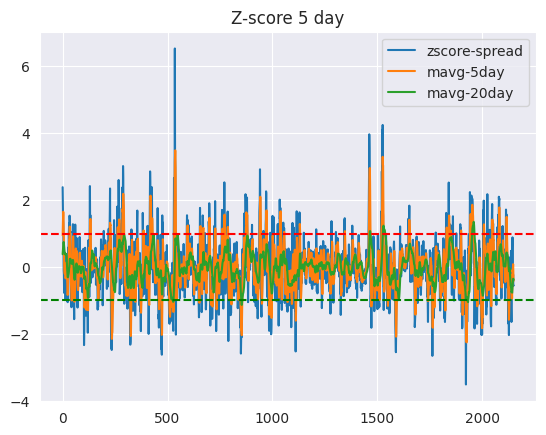

In [880]:
# plotting the graph
data_mlF_clean20['z_score_5_diff_x'].plot()
data_mlF_clean20['zscore_diff_mavg_5'].plot()
data_mlF_clean20['zscore_diff_mavg_20'].plot()
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.title('Z-score 5 day')
plt.legend(['zscore-spread','mavg-5day','mavg-20day'])

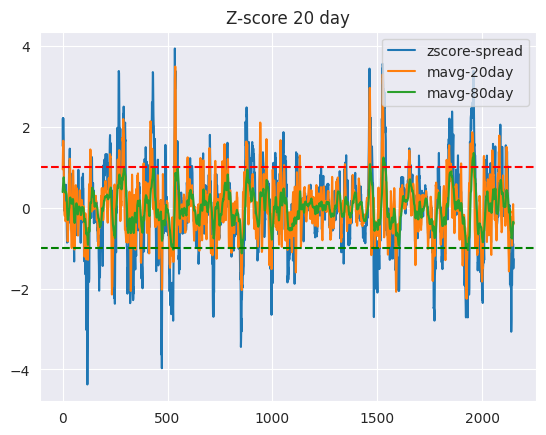

In [881]:
data_mlF_clean20['z_score_20_diff_x'].plot()
data_mlF_clean20['zscore_20_diff_mavg_20'].plot()
data_mlF_clean20['zscore_20_diff_mavg_80'].plot()
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.title('Z-score 20 day')
plt.legend(['zscore-spread','mavg-20day','mavg-80day'], loc='upper right')

In [882]:
# train data
data_mlF_clean.shape
train = data_mlF_clean[0:1667]
val = data_mlF_clean[1667:1917]
test = data_mlF_clean[1917:]

In [883]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [884]:
Y = train['Signal5_label']
X = train[['z_score_5_diff_x', 'zscore_diff_mavg_5', 'zscore_diff_mavg_20','std_20','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [885]:
# Training data classifier
clf = DecisionTreeClassifier(random_state = 1, min_samples_split = 12, max_depth = 10)#, min_samples_split = 10)
clf.fit(X, Y)
print(confusion_matrix(Y, clf.predict(X)))
print(accuracy_score(Y, clf.predict(X)))

[[556 109]
 [152 850]]
0.8434313137372526


In [886]:
preds = clf.predict_proba(X)
preds = [j[1] for j in preds]

In [887]:
# Validation dataset
Y = val['Signal5_label']
X = val[['z_score_5_diff_x', 'zscore_diff_mavg_5', 'zscore_diff_mavg_20','std_20','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [888]:
print(confusion_matrix(Y, clf.predict(X)))
print(accuracy_score(Y, clf.predict(X)))

In [889]:
# Test dataset
Y = test['Signal5_label']
X = test[['z_score_5_diff_x', 'zscore_diff_mavg_5', 'zscore_diff_mavg_20','std_20','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [890]:
print(confusion_matrix(Y, clf.predict(X)))
print(accuracy_score(Y, clf.predict(X)))

In [891]:
preds = clf.predict_proba(X)
preds = np.array(preds)


# Z_score_20 model

In [892]:
data_mlF_clean20

,index,Date,ICICI,AXIS,ICICI_ret,AXIS_ret,z_score_5_diff_x,z_score_20_diff_x,zscore_diff_mavg_5,zscore_diff_mavg_20,std_20,zscore_20_diff_mavg_20,zscore_20_diff_mavg_80,std_80,Signal5_label,Signal20_label,ICIC_mean,AXIS_mean
0,158,2015-08-20,257.345306,521.341187,-0.020526,-0.037184,2.382501,1.520819,0.944531,0.381503,0.841479,0.944531,0.381503,1.029919,-1.0,1.0,0.004494,-0.012228
1,159,2015-08-21,255.835403,513.424377,-0.005867,-0.015185,1.887047,2.202535,1.296273,0.480814,0.897131,1.296273,0.480814,1.039150,-1.0,-1.0,-0.004010,-0.016128
2,160,2015-08-24,232.926651,471.152100,-0.089545,-0.082334,1.412104,1.650329,1.494088,0.534839,0.919917,1.494088,0.534839,1.037078,-1.0,-1.0,-0.022118,-0.029577
3,161,2015-08-25,244.618286,491.579651,0.050194,0.043357,1.328081,2.206548,1.649729,0.641636,0.878904,1.649729,0.641636,1.053876,-1.0,-1.0,-0.010890,-0.020888
4,162,2015-08-26,239.915756,484.395813,-0.019224,-0.014614,0.672713,1.821713,1.536489,0.718854,0.803567,1.536489,0.718854,1.067124,-1.0,-1.0,-0.016993,-0.021192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2304,2024-05-07,1131.900024,1127.699951,-0.012562,-0.013947,-0.456383,-0.621433,-0.133239,-0.502814,0.760438,-0.133239,-0.502814,1.082248,1.0,1.0,-0.004896,-0.005471
2147,2305,2024-05-08,1123.000000,1128.650024,-0.007863,0.000842,-0.286785,-1.145390,-0.028306,-0.442509,0.724778,-0.028306,-0.442509,1.091259,1.0,1.0,-0.004788,-0.006450
2148,2306,2024-05-09,1115.699951,1115.650024,-0.006500,-0.011518,-0.227742,-0.893696,0.083196,-0.352212,0.621203,0.083196,-0.352212,1.096611,1.0,1.0,-0.004184,-0.006000
2149,2307,2024-05-10,1117.050049,1120.099976,0.001210,0.003989,-0.565585,-1.506058,-0.130311,-0.355597,0.622222,-0.130311,-0.355597,1.109421,1.0,1.0,-0.004399,-0.003750


In [893]:
train_20 = data_mlF_clean[0:1667]
val_20 = data_mlF_clean[1667:1917]
test_20 = data_mlF_clean[1917:]

In [894]:
Y_20 = train_20['Signal20_label']
X_20 = train_20[['z_score_20_diff_x', 'zscore_20_diff_mavg_20', 'zscore_20_diff_mavg_80','std_80','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [895]:
# Training data 20 classifier
clf_20 = DecisionTreeClassifier(random_state = 1, min_samples_split = 12, max_depth = 10)#, min_samples_split = 10)
clf_20.fit(X_20, Y_20)
print(confusion_matrix(Y_20, clf_20.predict(X_20)))
print(accuracy_score(Y_20, clf_20.predict(X_20)))

[[ 541   65]
 [  36 1025]]
0.9394121175764847


In [896]:
# Validation dataset
Y = val_20['Signal20_label']
X = val_20[['z_score_20_diff_x', 'zscore_20_diff_mavg_20', 'zscore_20_diff_mavg_80','std_80','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [897]:
# print(confusion_matrix(Y, clf_20.predict(X)))
# print(accuracy_score(Y, clf_20.predict(X)))

In [898]:
# Test dataset
Y = test_20['Signal20_label']
X = test_20[['z_score_20_diff_x', 'zscore_20_diff_mavg_20', 'zscore_20_diff_mavg_80','std_80','ICICI_ret','AXIS_ret','ICIC_mean', 'AXIS_mean']]

In [899]:
# print(confusion_matrix(Y, clf_20.predict(X)))
# print(accuracy_score(Y, clf_20.predict(X)))

In [900]:
# preds = clf.predict_proba(X)
# preds = [j[1] for j in preds]